Chris Padgett

Greg Peters

CSCI 4800 Data Science

# Final Project Code

## Data Collection

Data collection code is located in the github repository *Data Collection* folder.

## Raw data joining, parsing, cleaning, and division into learn/test datasets

In [10]:
###################################################################################
# Join and parse raw data                                                         #
###################################################################################
import os
import re
import csv
import json
import locale
import collections
import pickle

locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 

def parse_price(price):
    # eg: u'$237,000,000' --> 237000000
    if not price:
        return 0
    return locale.atoi(re.sub('[^0-9,]', "", price))

def parse_duration(duration_string):
    if not duration_string:
        return 0

    if "min" in duration_string:
        if "h" in duration_string: # eg: "2h 49min"
            s = duration_string.split("h")
            hours = int(s[0])
            if len(s) > 1: # has minute number
                if "min" in s[1]:
                    minutes = int(s[1].strip().split("min")[0])
                else:
                    minutes = 0
            else:
                minutes = 0
            return 60 * hours + minutes
        else: # eg: "169 min"
            return int(duration_string.split('min')[0])
    else:
        if "h" in duration_string: # eg: "2h"
            return int(duration_string.split('h')[0].strip()) * 60
        else:
            return None

def load_unparsed_movie_metadata():
    try:
        with open("Data Collection/imdb_output.json", "r") as f:
            movies = json.load(f)
            return movies
    except:
        print("  Cannot load the unparsed movie metadata file!")
        return None
    
def load_unparsed_movie_people():
    try:
        with open("Data Collection/imdb_people.json", "r") as f:
            movie_people = json.load(f)
            return movie_people
    except:
        print("  Cannot load the unparsed movie people metadata file!")
        return None

def parse_genres(genres):
    if not genres:
        return None
    return "|".join([g.strip() for g in sorted(genres)])

def parse_plot_keywords(words):
    if not words:
        return None
    return "|".join([w.strip() for w in sorted(words)])

def parse_cast_info(cast):
    if not cast:
        return None
    return "|".join([c['name_id'].strip() for c in sorted(cast)])

def parse_writer_info(writers):
    if not writers:
        return None
    return "|".join([w['name_id'].strip() for w in sorted(writers)])

def parse_aspect_ratio(ratio_string):
    if not ratio_string:
        return None
    if ":" in ratio_string:
        return float(ratio_string.split(":")[0].strip())
    else:
        return float(re.search('[0-9,.]+', ratio_string).group())

def parse_one_movie_metadata(movie, movie_people):
    if not movie:
        return None

    parsed_movie = {}

    parsed_movie['movie_imdb_link'] = movie['movie_imdb_link']
    parsed_movie['imdb_id'] = movie['imdb_id']
    parsed_movie['movie_title'] = movie['movie_title'].encode('utf-8')
    parsed_movie['num_voted_users'] = movie['num_voted_users']
    parsed_movie['plot_keywords'] = parse_plot_keywords(movie['plot_keywords'])
    parsed_movie['num_user_for_reviews'] = movie['num_user_for_reviews']
    parsed_movie['language'] = None if movie['language'] is None or len(movie['language']) == 0 else movie['language'][0] # choose the first language
    parsed_movie['country'] = None if movie['country'] is None or len(movie['country']) == 0 else movie['country'][0] # choose 1st country
    parsed_movie['genres'] = parse_genres(movie['genres'])
    parsed_movie['color'] = None if movie['color'] is None or len(movie['color']) == 0 else movie['color'][0]
    parsed_movie['gross'] = None if movie['gross'] is None or len(movie['gross']) == 0 else parse_price(movie['gross'][0].strip())
    parsed_movie['content_rating'] = None if movie['content_rating'] is None or len(movie['content_rating']) == 0 else movie['content_rating'][0].strip()
    parsed_movie['budget'] = None if movie['budget'] is None or len(movie['budget']) == 0 else parse_price(movie['budget'][0].strip())
    parsed_movie['title_year'] = None if movie['title_year'] is None else int(movie['title_year'])
    parsed_movie['storyline'] = None if movie['storyline'] is None else movie['storyline'].strip().encode('utf-8')
    parsed_movie['user_review_score'] = None if movie['user_review_score'] is None or len(movie['user_review_score']) == 0 else float(movie['user_review_score'][0].strip())
    parsed_movie['critic_review_score'] = None if movie['critic_review_score'] is None or len(movie['critic_review_score']) == 0 else float(movie['critic_review_score'][0].strip())
    parsed_movie['aspect_ratio'] = parse_aspect_ratio(movie['aspect_ratio'])
    parsed_movie['num_critic_for_reviews'] = None if movie['num_critic_for_reviews'] is None else movie['num_critic_for_reviews']

    # parse movie duration
    duration = movie['duration']
    if not duration:
        parsed_movie['duration'] = None
    else:
        if len(duration) == 1:
            parsed_movie['duration'] = parse_duration(duration[0].strip())
        else:
            parsed_movie['duration'] = parse_duration(duration[-1].strip())
    
    # parse director info
    director_info = movie['director_info']
    if not director_info:
        parsed_movie['director_name_id'] = None
    else:
        parsed_movie['director_name_id'] = director_info['name_id'].encode('utf-8')
        
    # parse cast and writer info
    for movie_crew in movie_people:
        if parsed_movie['imdb_id'] == movie_crew['imdb_id']:
            parsed_movie['cast_info'] = parse_cast_info(movie_crew['cast_info'])
            parsed_movie['writer_info'] = parse_writer_info(movie_crew['writer_info'])
            break

    return parsed_movie

def parse_all_movies():
    movies = load_unparsed_movie_metadata()
    total_movies = len(movies)
    print("  {} movie metadata were loaded!".format(total_movies))

    movie_people = load_unparsed_movie_people()
    total_movie_people = len(movie_people)
    print("  {} movie people data were loaded!".format(total_movie_people))
    
    with open("Datasets/movie_metadata_all.csv", "w") as f:
        header_was_written = False
        for i, movie in enumerate(movies):
            parsed_movie = parse_one_movie_metadata(movie, movie_people)
            w = csv.DictWriter(f, parsed_movie.keys())
            if not header_was_written:
                w.writeheader()
                header_was_written = True

            w.writerow(parsed_movie)
            if (i+1) % 500 == 0 or i+1 == total_movies:
                print("  Processed {} of {} movie metadata...".format(i+1, total_movies))
            
    print("  Movie metadata processing complete!")

def create_people_name_dict():
    print("\nCreating Name_id to Name dictionary:")
    movie_people = load_unparsed_movie_people()
    
    people_id_dict = {}
    for movie in movie_people:
        for actor in movie['cast_info']:
            people_id_dict[actor['name_id']] = actor['actor_name'].replace('\n', '')
            
        for writer in movie['writer_info']:
            people_id_dict[writer['name_id']] = writer['writer_name'].replace('\n', '')
    
    print("  Saving dictionary...")
    with open('Datasets/people_id_dictionary.pickle', 'wb') as handle:
        pickle.dump(people_id_dict, handle)
        
    print("  Name_id to Name dictionary created!")

print('Joining and parsing raw data:')
parse_all_movies()
create_people_name_dict()


###################################################################################
# Data Cleaning                                                                   #
###################################################################################
import pandas as pd
dirty_movie_data = pd.read_csv("Datasets/movie_metadata_all.csv")
required_fields = {'cast_info': 0, 'writer_info': 0}

def clean_movies(dirty_movie_data, required_fields):
    missing_data = []
    for i, movie in dirty_movie_data.iterrows():
        for req_field in required_fields:
            if pd.isnull(movie[req_field]):
                missing_data.append(movie['imdb_id'])
                required_fields[req_field] = required_fields[req_field] + 1
            
    for req_field in required_fields:
        print('  Movies missing {}: {}'.format(req_field, required_fields[req_field]))
    
    missing_data = set(missing_data)
    print('  Removing movies missing data...')
    return dirty_movie_data[~dirty_movie_data['imdb_id'].isin(missing_data)]

print('\nCleaning Data:')
clean_movie_data = clean_movies(dirty_movie_data, required_fields)
print('  Movies remaining: {}'.format(len(clean_movie_data)))


###################################################################################
# Create Critic and User Datasets                                                 #
###################################################################################
with open('Datasets/people_id_dictionary.pickle', 'rb') as handle:
    people_id_dict = pickle.load(handle)

min_required_critic_reviews = 10
min_required_user_reviews = 100

# Function to get a list of people from a people string
def get_people_list(people_string):
    return [name for name in people_string.split("|")]

def create_smaller_people_dict(mov_dataset, people_dict):
    new_dict = {}
    for i, movie in mov_dataset.iterrows():
        for person_id in get_people_list(movie['cast_info']):
            new_dict[person_id] = people_dict[person_id]
        for person_id in get_people_list(movie['writer_info']):
            new_dict[person_id] = people_dict[person_id]
            
    return new_dict

def create_critic_dataset(clean_movie_data, min_required_critic_reviews):
    dirty_critic_data = {'critic_review_score': [], 'num_critic_for_reviews': []}
    for i, movie in clean_movie_data.iterrows():
        if pd.isnull(movie['critic_review_score']):
            dirty_critic_data['critic_review_score'].append(movie['imdb_id'])
            
        if pd.isnull(movie['num_critic_for_reviews']) or movie['num_critic_for_reviews'] < min_required_critic_reviews:
            dirty_critic_data['num_critic_for_reviews'].append(movie['imdb_id'])
            
    print('  Critic Dataset - missing critic_review_score: {}'.format(len(dirty_critic_data['critic_review_score'])))
    print('  Critic Dataset - not enough reviews (<{}): {}'.format(min_required_critic_reviews, len(dirty_critic_data['num_critic_for_reviews'])))
    
    critic_removal_list = set(dirty_critic_data['critic_review_score'] + dirty_critic_data['num_critic_for_reviews'])
    print('  Removing movies from critic dataset...')
    return clean_movie_data[~clean_movie_data['imdb_id'].isin(critic_removal_list)]

def create_user_dataset(clean_movie_data, min_required_user_reviews):
    dirty_user_data = {'user_review_score': [], 'num_voted_users': []}
    for i, movie in clean_movie_data.iterrows():
        if pd.isnull(movie['user_review_score']):
            dirty_user_data['user_review_score'].append(movie['imdb_id'])
            
        if pd.isnull(movie['num_voted_users']) or movie['num_voted_users'] < min_required_user_reviews:
            dirty_user_data['num_voted_users'].append(movie['imdb_id'])
            
    print('  User Dataset - missing user_review_score: {}'.format(len(dirty_user_data['user_review_score'])))
    print('  User Dataset - not enough reviews (<{}): {}'.format(min_required_user_reviews, len(dirty_user_data['num_voted_users'])))
    
    user_removal_list = set(dirty_user_data['user_review_score'] + dirty_user_data['num_voted_users'])
    print('  Removing movies from user dataset...')
    return clean_movie_data[~clean_movie_data['imdb_id'].isin(user_removal_list)]

print('\nCreating Critic Dataset:')
full_critic_dataset = create_critic_dataset(clean_movie_data, min_required_critic_reviews)
print('  Full Critic Dataset contains {} movies'.format(len(full_critic_dataset)))
full_critic_dataset.to_csv('Datasets/full_critic_dataset.csv')
critic_people_dict = create_smaller_people_dict(full_critic_dataset, people_id_dict)
with open('Datasets/critic_people_id_dictionary.pickle', 'wb') as handle:
        pickle.dump(critic_people_dict, handle)
print('  Saved critic people dictionary containing {} people'.format(len(critic_people_dict)))

print('\nCreating User Dataset:')
full_user_dataset = create_user_dataset(clean_movie_data, min_required_user_reviews)
print('  Full User Dataset contains {} movies'.format(len(full_user_dataset)))
full_user_dataset.to_csv('Datasets/full_user_dataset.csv')
user_people_dict = create_smaller_people_dict(full_user_dataset, people_id_dict)
with open('Datasets/user_people_id_dictionary.pickle', 'wb') as handle:
        pickle.dump(user_people_dict, handle)
print('  Saved user people dictionary containing {} people'.format(len(user_people_dict)))


###################################################################################
# Create Critic and User Datasets                                                 #
###################################################################################
def divide_dataset_learn_test(dataset_path, learn_path, test_path, learn_mod):
    ds = pd.read_csv(dataset_path)
    print('  {} contains {} movies'.format(dataset_path, len(ds)))
    
    learn_ds = pd.DataFrame([row for i, row in ds.iterrows() if (i % learn_mod) != 0])
    test_ds = pd.DataFrame([row for i, row in ds.iterrows() if (i % learn_mod) == 0])
                    
    learn_ds.to_csv(learn_path)
    test_ds.to_csv(test_path)
            
learn_mod = 10
print('\nDividing Critic Dataset:')
divide_dataset_learn_test('Datasets/full_critic_dataset.csv', 'Datasets/learn_critic_dataset.csv', 'Datasets/test_critic_dataset.csv', learn_mod)
learn_critic_dataset = pd.read_csv('Datasets/learn_critic_dataset.csv')
test_critic_dataset = pd.read_csv('Datasets/test_critic_dataset.csv')
print('  Critic Learning Dataset size: {}'.format(len(learn_critic_dataset)))
print('  Critic Testing Dataset size: {}'.format(len(test_critic_dataset)))

print('\nDividing User Dataset:')
divide_dataset_learn_test('Datasets/full_user_dataset.csv', 'Datasets/learn_user_dataset.csv', 'Datasets/test_user_dataset.csv', learn_mod)
learn_user_dataset = pd.read_csv('Datasets/learn_user_dataset.csv')
test_user_dataset = pd.read_csv('Datasets/test_user_dataset.csv')
print('  User Learning Dataset size: {}'.format(len(learn_user_dataset)))
print('  User Testing Dataset size: {}'.format(len(test_user_dataset)))

Joining and parsing raw data:
  5221 movie metadata were loaded!
  5221 movie people data were loaded!
  Processed 500 of 5221 movie metadata...
  Processed 1000 of 5221 movie metadata...
  Processed 1500 of 5221 movie metadata...
  Processed 2000 of 5221 movie metadata...
  Processed 2500 of 5221 movie metadata...
  Processed 3000 of 5221 movie metadata...
  Processed 3500 of 5221 movie metadata...
  Processed 4000 of 5221 movie metadata...
  Processed 4500 of 5221 movie metadata...
  Processed 5000 of 5221 movie metadata...
  Processed 5221 of 5221 movie metadata...
  Movie metadata processing complete!

Creating Name_id to Name dictionary:
  Saving dictionary...
  Name_id to Name dictionary created!

Cleaning Data:
  Movies missing cast_info: 28
  Movies missing writer_info: 335
  Removing movies missing data...
  Movies remaining: 4886

Creating Critic Dataset:
  Critic Dataset - missing critic_review_score: 1144
  Critic Dataset - not enough reviews (<10): 303
  Removing movies fr

## Average Value Prediction


Displaying Average Value Prediction results for user review scores based on cast


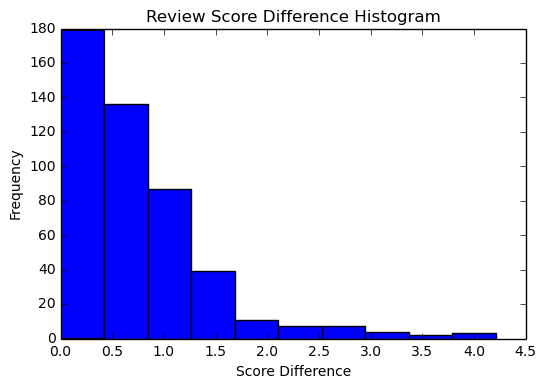

Test Results based on 478 test movies
Average error is 0.746631612788 on an out of 10 scale
Percent error is 13.9141019906

Displaying Average Value Prediction results for user review scores based on writers


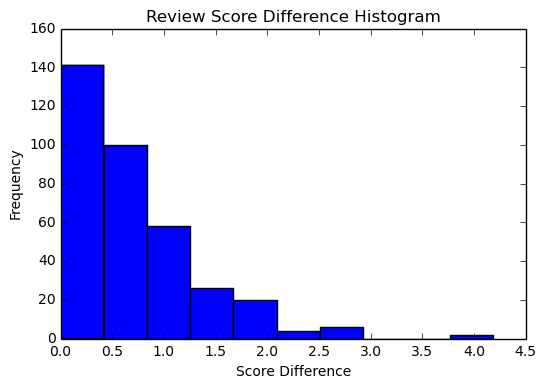

Test Results based on 478 test movies
Average error is 0.715606402333 on an out of 10 scale
Percent error is 12.1144043356

Displaying Average Value Prediction results for critic review scores based on cast


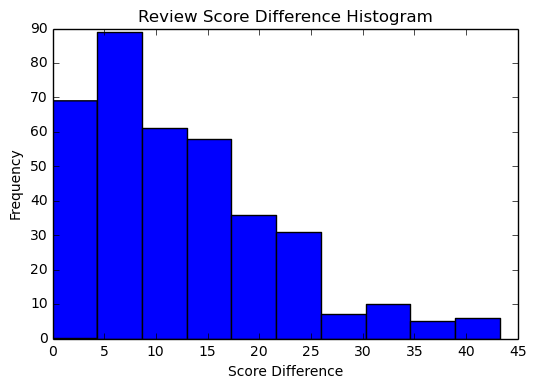

Test Results based on 372 test movies
Average error is 12.3554012645 on an out of 100 scale
Percent error is 30.0122245989

Displaying Average Value Prediction results for critic review scores based on writers


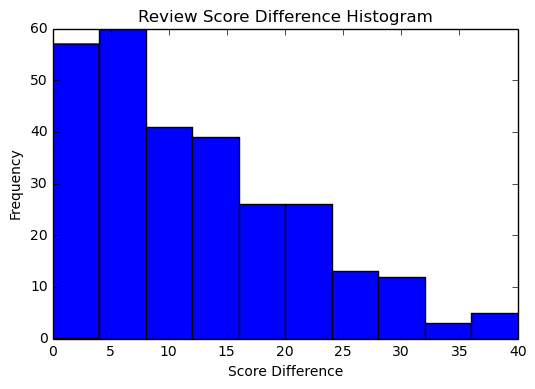

Test Results based on 372 test movies
Average error is 12.0792032002 on an out of 100 scale
Percent error is 25.520688125


In [11]:
import csv
import pickle
import numpy as np
import pandas as pd

# Datasets for machine learning
learn_user_movdata = pd.read_csv('Datasets/learn_user_dataset.csv')
learn_critic_movdata = pd.read_csv('Datasets/learn_critic_dataset.csv')

# Datasets for testing predictions
test_user_movdata = pd.read_csv('Datasets/test_user_dataset.csv')
test_critic_movdata = pd.read_csv('Datasets/test_critic_dataset.csv')

# Load people id dictionary
with open('Datasets/people_id_dictionary.pickle', 'rb') as handle:
    people_id_dict = pickle.load(handle)
    
    
# Function to get a list of people from a people string
def get_people_list(people_string):
    return [name for name in people_string.split("|")]


# Function to get person name from person_id
def get_person_name(people_dict, name_id):
    return people_dict[name_id]
    
    
# Function to create Average Value Prediction dictionary
def train_avp(training_dataset, people_dict, review_tag, person_tag):
    avp_list_dict = {}
    avp_dict = {}
    for person in people_dict:
        avp_list_dict[person] = []
        avp_dict[person] = None
        
    for i, movie in training_dataset.iterrows():
        for person in get_people_list(movie[person_tag]):
            avp_list_dict[person].append(movie[review_tag])
    
    for person, rating_list in avp_list_dict.iteritems():
        avp_dict[person] = np.mean(rating_list) if rating_list is not None else None
        
    return avp_dict


%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate percentage error
def calc_percent_error(experiment_result, actual_result):
    return abs((experiment_result - actual_result) / actual_result) * 100
    
    
# Function to predict rating of a movie
def predict_ratings(prediction_dict, test_movie_data, review_tag, person_tag):
    predicted_list = {}
    for i, movie in test_movie_data.iterrows():
        predicted_list[movie['imdb_id']] = []
        for person_id in get_people_list(movie[person_tag]):
            predicted_list[movie['imdb_id']].append(prediction_dict[person_id])
        
    predicted_movies = {}
    for movie_id, rating_list in predicted_list.iteritems():
        predicted_movies[movie_id] = np.nanmean(rating_list)
        
    return predicted_movies


# Function to calculate statistics for Average Value Prediction
def calc_AVP_stats(avp_prediction, test_movdata, review_tag, person_tag):
    movies_stats_dict = {}
    avp_stats_dict = {'person_tag': person_tag, 'review_tag': review_tag, 'movies_predicted': len(avp_prediction)}
    avp_stats_dict['person_tag_str'] = "user" if avp_stats_dict['review_tag'] is "user_review_score" else "critic"
    avp_stats_dict['review_tag_str'] = "cast" if avp_stats_dict['person_tag'] is "cast_info" else "writers"
    avp_stats_dict['review_scale_max'] = 10 if avp_stats_dict['review_tag'] is "user_review_score" else 100
    
    # Calculate differences
    for i, movie in test_movdata.iterrows():
        stats_dict = {}
        stats_dict['actual_review_score'] = movie[review_tag]
        stats_dict['predicted_review_score'] = avp_prediction[movie['imdb_id']]
        stats_dict['review_score_difference'] = abs(movie[review_tag] - avp_prediction[movie['imdb_id']])
        stats_dict['percent_error'] = calc_percent_error(stats_dict['predicted_review_score'], stats_dict['actual_review_score'])
        
        movies_stats_dict[movie['imdb_id']] = stats_dict
            
    avp_stats_dict['movies'] = movies_stats_dict
    
    # Create review difference list, and percent error list
    review_diff_list = []
    percent_error_list = []
    for movie_id, stats_dict in avp_stats_dict['movies'].iteritems():
        if not np.isnan(stats_dict['review_score_difference']):
            review_diff_list.append(stats_dict['review_score_difference'])
        if not np.isnan(stats_dict['percent_error']):
            percent_error_list.append(stats_dict['percent_error'])
            
    avp_stats_dict['review_score_difference_list'] = review_diff_list
    avp_stats_dict['average_error'] = np.mean(review_diff_list)
    avp_stats_dict['average_percent_error'] = np.mean(percent_error_list)
            
    return avp_stats_dict


# Function to display Average Value Prediction accuracy
def display_avp_accuracy(avp_stats_dict):
    plt.hist(avp_stats_dict['review_score_difference_list'])
    plt.title("Review Score Difference Histogram")
    plt.xlabel("Score Difference")
    plt.ylabel("Frequency")
    plt.show()
    
    print("Test Results based on {} test movies".format(avp_stats_dict['movies_predicted']))
    print("Average error is {} on an out of {} scale".format(avp_stats_dict['average_error'], avp_stats_dict['review_scale_max']))
    print("Percent error is {}".format(avp_stats_dict['average_percent_error']))

# Function to display all prediction results
def display_all_results(avp_prediction, test_movdata, review_tag, person_tag):
    avp_stats = calc_AVP_stats(avp_prediction, test_movdata, review_tag, person_tag)
    print('\n====================================================================================================')
    print("Displaying Average Value Prediction results for {} review scores based on {}".format(
        avp_stats['person_tag_str'], avp_stats['review_tag_str']))
    
    display_avp_accuracy(avp_stats)
    

# Create the prediction dictionaries
user_cast_avp_dict = train_avp(learn_user_movdata, people_id_dict, 'user_review_score', 'cast_info')
user_writer_avp_dict = train_avp(learn_user_movdata, people_id_dict, 'user_review_score', 'writer_info')
critic_cast_avp_dict = train_avp(learn_critic_movdata, people_id_dict, 'critic_review_score', 'cast_info')
critic_writer_avp_dict = train_avp(learn_critic_movdata, people_id_dict, 'critic_review_score', 'writer_info')

# Get Average Value Predictions
predicted_user_cast_movies = predict_ratings(user_cast_avp_dict, test_user_movdata, 'user_review_score', 'cast_info')
predicted_user_writer_movies = predict_ratings(user_writer_avp_dict, test_user_movdata, 'user_review_score', 'writer_info')
predicted_critic_cast_movies = predict_ratings(critic_cast_avp_dict, test_critic_movdata, 'critic_review_score', 'cast_info')
predicted_critic_writer_movies = predict_ratings(critic_writer_avp_dict, test_critic_movdata, 'critic_review_score', 'writer_info')

# Display results
display_all_results(predicted_user_cast_movies, test_user_movdata, 'user_review_score', 'cast_info')
display_all_results(predicted_user_writer_movies, test_user_movdata, 'user_review_score', 'writer_info')
display_all_results(predicted_critic_cast_movies, test_critic_movdata, 'critic_review_score', 'cast_info')
display_all_results(predicted_critic_writer_movies, test_critic_movdata, 'critic_review_score', 'writer_info')

## Bayesian Average Weighted Prediction

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/L


Displaying Average Value Prediction results for user review scores based on cast


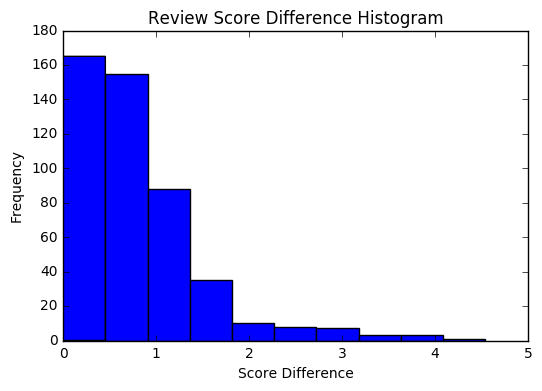

Test Results based on 478 test movies
Average error is 0.7943381521605364 on an out of 10 scale
Percent error is 14.730491425998267

Displaying Average Value Prediction results for user review scores based on writers


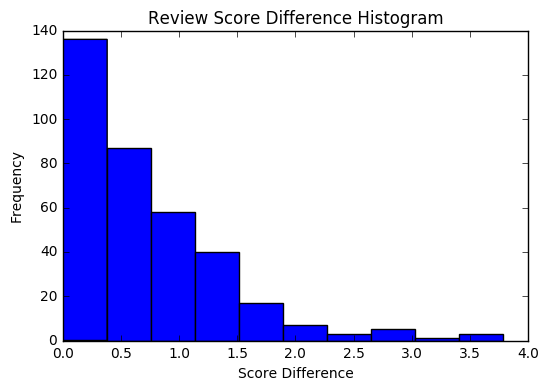

Test Results based on 478 test movies
Average error is 0.7316608727181054 on an out of 10 scale
Percent error is 12.847213180713467

Displaying Average Value Prediction results for critic review scores based on cast


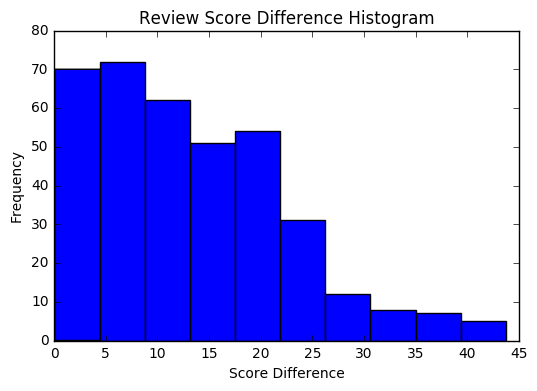

Test Results based on 372 test movies
Average error is 13.267698503108925 on an out of 100 scale
Percent error is 32.64232461296587

Displaying Average Value Prediction results for critic review scores based on writers


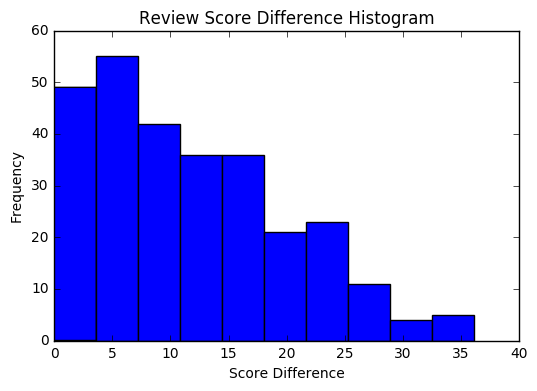

Test Results based on 372 test movies
Average error is 11.937147720676192 on an out of 100 scale
Percent error is 26.985582279492153


In [3]:
import csv
import pickle
import numpy as np
import pandas as pd

# Datasets for machine learning
learn_user_movdata = pd.read_csv('Datasets/learn_user_dataset.csv')
learn_critic_movdata = pd.read_csv('Datasets/learn_critic_dataset.csv')

# Datasets for testing predictions
test_user_movdata = pd.read_csv('Datasets/test_user_dataset.csv')
test_critic_movdata = pd.read_csv('Datasets/test_critic_dataset.csv')

# Load people id dictionary
with open('Datasets/people_id_dictionary.pickle', 'rb') as handle:
    people_id_dict = pickle.load(handle)
    
    
# Function to get a list of people from a people string
def get_people_list(people_string):
    return [name for name in people_string.split("|")]


# Function to get person name from person_id
def get_person_name(people_dict, name_id):
    return people_dict[name_id]
    
    
# Function to create Average Value Prediction dictionary
def train_bayesian(training_dataset, people_dict, review_tag, person_tag):
    bayesian_list_dict = {}
    bayesian_dict = {}
    for person in people_dict:
        bayesian_list_dict[person] = []
        bayesian_dict[person] = None
    
    for i, movie in training_dataset.iterrows():
        for person in get_people_list(movie[person_tag]):
            bayesian_list_dict[person].append(movie[review_tag])
    
    total_ratings = 0
    rating_count = 0
    total_count = 0
    
    for person, rating_list in bayesian_list_dict.items():
        total_ratings += np.sum(rating_list) if rating_list is not None else None
        rating_count += len(rating_list) if rating_list is not None else None
    
    for person, rating_list in bayesian_list_dict.items():
        bayesian_dict[person] = ((len(rating_list) * np.mean(rating_list)) + (3 * (total_ratings/rating_count)))/(len(rating_list) + 3)
    
    return bayesian_dict

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate percentage error
def calc_percent_error(experiment_result, actual_result):
    return abs((experiment_result - actual_result) / actual_result) * 100
    
    
# Function to predict rating of a movie
def predict_ratings(prediction_dict, test_movie_data, review_tag, person_tag):
    predicted_list = {}
    for i, movie in test_movie_data.iterrows():
        predicted_list[movie['imdb_id']] = []
        for person_id in get_people_list(movie[person_tag]):
            predicted_list[movie['imdb_id']].append(prediction_dict[person_id])
        
    predicted_movies = {}
    for movie_id, rating_list in predicted_list.items():
        predicted_movies[movie_id] = np.nanmean(rating_list)
        
    return predicted_movies


# Function to calculate statistics for Average Value Prediction
def calc_bayesian_stats(bayesian_prediction, test_movdata, review_tag, person_tag):
    movies_stats_dict = {}
    bayesian_stats_dict = {'person_tag': person_tag, 'review_tag': review_tag, 'movies_predicted': len(bayesian_prediction)}
    bayesian_stats_dict['person_tag_str'] = "user" if bayesian_stats_dict['review_tag'] is "user_review_score" else "critic"
    bayesian_stats_dict['review_tag_str'] = "cast" if bayesian_stats_dict['person_tag'] is "cast_info" else "writers"
    bayesian_stats_dict['review_scale_max'] = 10 if bayesian_stats_dict['review_tag'] is "user_review_score" else 100
    
    # Calculate differences
    for i, movie in test_movdata.iterrows():
        stats_dict = {}
        stats_dict['actual_review_score'] = movie[review_tag]
        stats_dict['predicted_review_score'] = bayesian_prediction[movie['imdb_id']]
        stats_dict['review_score_difference'] = abs(movie[review_tag] - bayesian_prediction[movie['imdb_id']])
        stats_dict['percent_error'] = calc_percent_error(stats_dict['predicted_review_score'], stats_dict['actual_review_score'])
        
        movies_stats_dict[movie['imdb_id']] = stats_dict
            
    bayesian_stats_dict['movies'] = movies_stats_dict
    
    # Create review difference list, and percent error list
    review_diff_list = []
    percent_error_list = []
    for movie_id, stats_dict in bayesian_stats_dict['movies'].items():
        if not np.isnan(stats_dict['review_score_difference']):
            review_diff_list.append(stats_dict['review_score_difference'])
        if not np.isnan(stats_dict['percent_error']):
            percent_error_list.append(stats_dict['percent_error'])
            
    bayesian_stats_dict['review_score_difference_list'] = review_diff_list
    bayesian_stats_dict['average_error'] = np.mean(review_diff_list)
    bayesian_stats_dict['average_percent_error'] = np.mean(percent_error_list)
            
    return bayesian_stats_dict


# Function to display Average Value Prediction accuracy
def display_bayesian_accuracy(bayesian_stats_dict):
    plt.hist(bayesian_stats_dict['review_score_difference_list'])
    plt.title("Review Score Difference Histogram")
    plt.xlabel("Score Difference")
    plt.ylabel("Frequency")
    plt.show()
    
    print("Test Results based on {} test movies".format(bayesian_stats_dict['movies_predicted']))
    print("Average error is {} on an out of {} scale".format(bayesian_stats_dict['average_error'], bayesian_stats_dict['review_scale_max']))
    print("Percent error is {}".format(bayesian_stats_dict['average_percent_error']))

# Function to display all prediction results
def display_all_results(bayesian_prediction, test_movdata, review_tag, person_tag):
    bayesian_stats = calc_bayesian_stats(bayesian_prediction, test_movdata, review_tag, person_tag)
    print('\n====================================================================================================')
    print("Displaying Average Value Prediction results for {} review scores based on {}".format(
        bayesian_stats['person_tag_str'], bayesian_stats['review_tag_str']))
    
    display_bayesian_accuracy(bayesian_stats)
    

# Create the prediction dictionaries
user_cast_bayesian_dict = train_bayesian(learn_user_movdata, people_id_dict, 'user_review_score', 'cast_info')
user_writer_bayesian_dict = train_bayesian(learn_user_movdata, people_id_dict, 'user_review_score', 'writer_info')
critic_cast_bayesian_dict = train_bayesian(learn_critic_movdata, people_id_dict, 'critic_review_score', 'cast_info')
critic_writer_bayesian_dict = train_bayesian(learn_critic_movdata, people_id_dict, 'critic_review_score', 'writer_info')

# Get Average Value Predictions
predicted_user_cast_movies = predict_ratings(user_cast_bayesian_dict, test_user_movdata, 'user_review_score', 'cast_info')
predicted_user_writer_movies = predict_ratings(user_writer_bayesian_dict, test_user_movdata, 'user_review_score', 'writer_info')
predicted_critic_cast_movies = predict_ratings(critic_cast_bayesian_dict, test_critic_movdata, 'critic_review_score', 'cast_info')
predicted_critic_writer_movies = predict_ratings(critic_writer_bayesian_dict, test_critic_movdata, 'critic_review_score', 'writer_info')

# Display results
display_all_results(predicted_user_cast_movies, test_user_movdata, 'user_review_score', 'cast_info')
display_all_results(predicted_user_writer_movies, test_user_movdata, 'user_review_score', 'writer_info')
display_all_results(predicted_critic_cast_movies, test_critic_movdata, 'critic_review_score', 'cast_info')
display_all_results(predicted_critic_writer_movies, test_critic_movdata, 'critic_review_score', 'writer_info')

## Linear Regression

In [8]:
import csv
import pickle
import numpy as np
import pandas as pd

# Datasets for machine learning
learn_user_movdata = pd.read_csv('Datasets/learn_user_dataset.csv')
learn_critic_movdata = pd.read_csv('Datasets/learn_critic_dataset.csv')

# Datasets for testing predictions
test_user_movdata = pd.read_csv('Datasets/test_user_dataset.csv')
test_critic_movdata = pd.read_csv('Datasets/test_critic_dataset.csv')

# Load user people_id dictionary
with open('Datasets/user_people_id_dictionary.pickle', 'rb') as handle:
    user_people_id_dict = pickle.load(handle)
    
# Load critic people_id dictionary
with open('Datasets/critic_people_id_dictionary.pickle', 'rb') as handle:
    critic_people_id_dict = pickle.load(handle)

# Function to get a column from a dataset
def get_col(colname, dataset):
    return [x[colname] for i, x in dataset.iterrows()]


# Function to get a list of people from a people string
def get_people_list(people_string):
    return [name for name in people_string.split("|")]


# Function to get person name from person_id
def get_person_name(people_dict, name_id):
    return people_dict[name_id]
    
    
# Function to create linear regression dataset
def create_lin_reg_data(mov_dataset, people_dict, review_tag, person_tag, out_dataset_file_path):
    print("    Writing dataset to '{}'".format(out_dataset_file_path))
    total_movies = len(mov_dataset)
    print("      {} people in this dataset".format(len(people_dict)))
    
    with open(out_dataset_file_path, "w") as f:
        movie_row = {}
        movie_row['imdb_id'] = 0
        movie_row[review_tag] = 0
        for person_id in people_dict.iterkeys():
            movie_row[person_id] = 0
            
        w = csv.DictWriter(f, movie_row.keys())
        w.writeheader()

        for i, movie in mov_dataset.iterrows():
            movie_row['imdb_id'] = movie['imdb_id']
            movie_row[review_tag] = movie[review_tag]

            movie_people = get_people_list(movie[person_tag])
            for person_id in people_dict.iterkeys():
                movie_row[person_id] = 1 if person_id in movie_people else 0

            w.writerow(movie_row)
            if (i+1) % 500 == 0 or i+1 == total_movies:
                print("      Processed {} of {} movies...".format(i+1, total_movies))
                
    print("    Finished writing file {}\n".format(out_dataset_file_path))


# Learn Linear Regression Datasets
print("Working on Learn Datasets")
print("  User Reviews")
learn_user_cast_data_file = 'Datasets/lin_reg/learn_user_cast_lin_reg.csv'
create_lin_reg_data(learn_user_movdata, user_people_id_dict, 'user_review_score', 'cast_info', learn_user_cast_data_file)

learn_user_writer_data_file = 'Datasets/lin_reg/learn_user_writer_lin_reg.csv'
create_lin_reg_data(learn_user_movdata, user_people_id_dict, 'user_review_score', 'writer_info', learn_user_writer_data_file)

print("  Critic Reviews")
learn_critic_cast_data_file = 'Datasets/lin_reg/learn_critic_cast_lin_reg.csv'
create_lin_reg_data(learn_critic_movdata, user_people_id_dict, 'critic_review_score', 'cast_info', learn_critic_cast_data_file)

learn_critic_writer_data_file = 'Datasets/lin_reg/learn_critic_writer_lin_reg.csv'
create_lin_reg_data(learn_critic_movdata, user_people_id_dict, 'critic_review_score', 'writer_info', learn_critic_writer_data_file)

# Test Linear Regression Datasets
print("Working on Test Datasets")
print("  User Reviews")
test_user_cast_data_file = 'Datasets/lin_reg/test_user_cast_lin_reg.csv'
create_lin_reg_data(test_user_movdata, critic_people_id_dict, 'user_review_score', 'cast_info', test_user_cast_data_file)

test_user_writer_data_file = 'Datasets/lin_reg/test_user_writer_lin_reg.csv'
create_lin_reg_data(test_user_movdata, critic_people_id_dict, 'user_review_score', 'writer_info', test_user_writer_data_file)

print("  Critic Reviews")
test_critic_cast_data_file = 'Datasets/lin_reg/test_critic_cast_lin_reg.csv'
create_lin_reg_data(test_critic_movdata, critic_people_id_dict, 'critic_review_score', 'cast_info', test_critic_cast_data_file)

test_critic_writer_data_file = 'Datasets/lin_reg/test_critic_writer_lin_reg.csv'
create_lin_reg_data(test_critic_movdata, critic_people_id_dict, 'critic_review_score', 'writer_info', test_critic_writer_data_file)

Working on Learn Datasets
  User Reviews
    Writing dataset to 'Datasets/lin_reg/learn_user_cast_lin_reg.csv'
      177774 people in this dataset


KeyboardInterrupt: 